# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import collections

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("Acrobot-v1")

env = make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

print(state_shape, n_actions)

[2017-10-01 05:21:14,071] Making new env: Acrobot-v1


(6,) 3


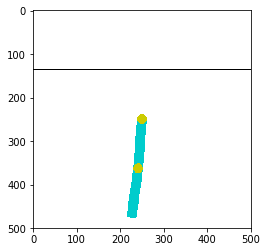

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Tensorflow version

In [49]:
import tensorflow as tf
print(tf.__version__)
assert tf.__version__ > "1.0.0", "try pip install --upgrade tensorflow(-gpu)"
tf.reset_default_graph()

1.2.1


In [50]:
# handle parameters
MEMORY_CAPACITY = 10000
EPSILON = .05
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.05
GAMMA = 0.99
MINI_BATCH_SIZE = 128
NUM_UPDATE_TARGET = 100

LEARNING_RATE = 0.001
REGULARIZATION = 0.0005
HIDDEN_SIZE = 256
SAVE_PATH = "ckpt/"

ID = 0
EPISODES = 6000
STEPS = 500
ENVIRONMENT = "Acrobot-v1"

dqn_params = {'memory_capacity': MEMORY_CAPACITY, 
              'epsilon': EPSILON,
              'epsilon_decay': EPSILON_DECAY, 
              'min_epsilon': MIN_EPSILON,
              'gamma': GAMMA, 
              'mini_batch_size': MINI_BATCH_SIZE,
              'num_update_target': NUM_UPDATE_TARGET}

nn_params = {'lr': LEARNING_RATE, 
             'reg': REGULARIZATION,
             'hidden_size': HIDDEN_SIZE,
             'model_save_path': SAVE_PATH}

run_id = '_'.join([str(k) + '_' + str(v) for k, v in dqn_params.items()] + 
                  [str(k) + '_' + str(v) for k, v in nn_params.items()])
print(run_id)

agent_params = {'episodes': EPISODES,
                'steps': STEPS, 
                'environment':ENVIRONMENT, 
                'run_id': run_id}

mini_batch_size_128_epsilon_decay_0.999_memory_capacity_10000_epsilon_0.05_gamma_0.99_num_update_target_100_min_epsilon_0.05_lr_0.001_model_save_path_ckpt/_hidden_size_256_reg_0.0005


In [51]:
# define NN
class NN:
    """
    Neural Network model
    """
    
    def __init__(self, num_actions, state_dim, params={}):
        """
        Initialize the NN model with a set of parameters.
        Args:
            params: a dictionary containing values of the models' parameters.
        """

        self.num_actions = num_actions
        self.state_dim = state_dim

        self.lr = params['lr']
        self.reg = params['reg']
        self.hidden_size = params['hidden_size']
        self.path = params['model_save_path']
        os.makedirs(self.path, exist_ok=True)
        self.session = tf.Session()
        self.create_model()

    def add_placeholders(self):
        state_placeholder = tf.placeholder(tf.float32, shape=(None, self.state_dim))
        value_placeholder = tf.placeholder(tf.float32, shape=(None,))
        action_placeholder = tf.placeholder(tf.float32, shape=(None, self.num_actions))

        return state_placeholder, value_placeholder, action_placeholder
    
    def nn(self, state_node, name='net'):
        
        with tf.variable_scope(name) as scope:
            W1shape = [self.state_dim, self.hidden_size]
            W1 = tf.get_variable("W1", shape=W1shape,)
            bshape = [1, self.hidden_size]
            b1 = tf.get_variable("b1", shape=bshape, initializer = tf.constant_initializer(0.0))

            W2shape = [self.hidden_size, self.hidden_size]
            W2 = tf.get_variable("W2", shape=W2shape,)
            bshape = [1, self.hidden_size]
            b2 = tf.get_variable("b2", shape=bshape, initializer = tf.constant_initializer(0.0))

            Ushape = [self.hidden_size, self.num_actions]
            U = tf.get_variable("U", shape=Ushape)
            b3shape = [1, self.num_actions]
            b3 = tf.get_variable("b3", shape=b3shape, initializer = tf.constant_initializer(0.0))
        
        xW = tf.matmul(state_node, W1)
        h = tf.tanh(tf.add(xW, b1))

        xW = tf.matmul(h, W2)
        h = tf.tanh(tf.add(xW, b2))

        hU = tf.matmul(h, U)    
        out = tf.add(hU, b3)

        reg = self.reg * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2)) + tf.reduce_sum(tf.square(U)))
        return out, reg
    
    def copy_variables(self, target, source):
        target_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=target)
        source_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=source)
        copy = [x.assign(y) for x, y in zip(target_variables, source_variables)]
        return copy

    def create_model(self):
        """
        The model definition.
        """
        self.state_placeholder, self.value_placeholder, self.action_placeholder = self.add_placeholders()
        outputs, reg = self.nn(self.state_placeholder, name='changeable')
        self.predictions = outputs
        
        self.preds_by_fixed, _ = self.nn(self.state_placeholder, name='fixed')
        self.q_vals = tf.reduce_sum(tf.multiply(self.predictions, self.action_placeholder), 1)
        self.loss = tf.reduce_sum(tf.square(self.value_placeholder - self.q_vals)) + reg
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        self.update_target = self.copy_variables('fixed', 'changeable')
        
        init = tf.global_variables_initializer()
        session = self.session
        session.run(init)
        session.run(self.update_target)
        
        # tensorboard
        writer = tf.summary.FileWriter("/tmp/tboard", graph=tf.get_default_graph())
        writer.close()
        
        # restore model if it exists
        model_file = tf.train.latest_checkpoint(self.path)
        self.saver = tf.train.Saver(max_to_keep=1)
        if model_file:
            self.saver.restore(self.session, model_file)

    def train_step(self, Xs, ys, actions):
        """
        Updates the CNN model with a mini batch of training examples.
        """

        self.session.run(self.train_op, feed_dict = {self.state_placeholder: Xs,
                                                     self.value_placeholder: ys,
                                                     self.action_placeholder: actions
                                                    })

    def predict(self, state):
        """
        Predicts the rewards for an input observation state. 
        Args:
        observation: a numpy array of a single observation state
        """

        return self.session.run(self.predictions,
                                feed_dict = {self.state_placeholder: state})
    
    def predict_by_fixed(self, state):

        return self.session.run(self.preds_by_fixed,
                                feed_dict = {self.state_placeholder: state})
    
    def update_fixed_target(self):

        return self.session.run(self.update_target)

In [52]:
# define agent
class DQN:

    def __init__(self, num_actions, state_dim, dqn_params, cnn_params):
        self.num_actions = num_actions
        self.epsilon = dqn_params['epsilon']
        self.epsilon_decay = dqn_params['epsilon_decay']
        self.min_epsilon = dqn_params['min_epsilon']
        self.gamma = dqn_params['gamma']
        self.mini_batch_size = dqn_params['mini_batch_size']
        self.num_update_target = dqn_params['num_update_target']
        self.ACT_ID = 0
        self.STATE_ID = 1
        self.NEW_STATE_ID = 2
        self.REWARD_ID = 3
        self.DONE_ID = 4

        # memory 
        self.memory = [collections.deque(maxlen=dqn_params['memory_capacity']) for _ in range(5)]

        # initialize network
        self.model = NN(num_actions, state_dim, cnn_params)
        print("model initialized")

    def select_action(self, state):
        """
        Selects the next action to take based on the current state and learned Q.
        Args:
          observation: the current state
        """

        if np.random.rand() < self.epsilon:
            # with epsilon probability select a random action
            action = np.random.choice(self.num_actions)
        else:
            # select the action a which maximizes the Q value
            q_values = self.model.predict([state])
            action = np.argmax(q_values)

        return action

    def add_memory(self, action, state, new_state, reward, done):
        """
        Stores the most recent action in the replay memory.
        Args: 
          action: the action taken 
          observation: the state before the action was taken
          new_observation: the state after the action is taken
          reward: the reward from the action
          done: a boolean for when the episode has terminated 
        """
        action_one_hot = np.zeros(self.num_actions)
        action_one_hot[action] = 1
        
        self.memory[self.ACT_ID].append(action_one_hot)
        self.memory[self.STATE_ID].append(state)
        self.memory[self.NEW_STATE_ID].append(new_state)
        self.memory[self.REWARD_ID].append(reward)
        self.memory[self.DONE_ID].append(done)

    def get_random_mini_batch(self):
        """
        Gets a random sample of transitions from the replay memory.
        """
        idx = np.random.choice(len(self.memory[0]), self.mini_batch_size)
        return [[sub[ind] for ind in idx] for sub in self.memory]

    def train_step(self):
        """
        Updates the model based on the mini batch
        """
        if len(self.memory[0]) > self.mini_batch_size:
            acts, Xs, nXs, rs, dones = self.get_random_mini_batch()
            q_new_values = self.model.predict_by_fixed(nXs)
            ys = np.max(q_new_values, axis=1)
            ys = self.gamma*ys*(dones!=1) + rs
            self.model.train_step(Xs, ys, acts)

In [53]:
# run
def run_dqn():
    
    env = gym.make(agent_params['environment'])
    episodes = agent_params['episodes']
    steps = agent_params['steps']
    num_actions = env.action_space.n
    state_dim = np.product(env.observation_space.shape)

    # initialize dqn learning
    dqn = DQN(num_actions, state_dim, dqn_params, nn_params)

    last_100 = collections.deque(maxlen=100)
    start = time.time()

    for i_episode in range(episodes):
        state = env.reset()
        reward_sum = 0

        for t in range(steps):

            # select action based on the model
            action = dqn.select_action(state)
            # execute actin in emulator
            new_state, reward, done, _ = env.step(action)
            # update the state 
            dqn.add_memory(action, state, new_state, reward, done)
            state = new_state

            # train the model
            dqn.train_step()

            reward_sum += reward
            if done:
                print("Episode ", i_episode)
                print("Finished after {} timesteps".format(t+1))
                print("Reward for this episode: ", reward_sum)
                last_100.append(reward_sum)
                print("Average reward for last 100 episodes: ", np.mean(last_100))
                break

        if i_episode % dqn.num_update_target == 0:
            dqn.model.update_fixed_target()
            print("update target Q net")
            dqn.model.saver.save(dqn.model.session, dqn.model.path + "mod", global_step=i_episode)
            print('epsilon:', dqn.epsilon)
            
        dqn.epsilon = max(dqn.epsilon * dqn.epsilon_decay, dqn.min_epsilon) 


In [54]:
run_dqn()

[2017-08-18 14:54:03,853] Making new env: Acrobot-v1


INFO:tensorflow:Restoring parameters from ckpt/mod-3000


[2017-08-18 14:54:04,209] Restoring parameters from ckpt/mod-3000


model initialized
Episode  0
Finished after 139 timesteps
Reward for this episode:  -138.0
Average reward for last 100 episodes:  -138.0
update target Q net
epsilon: 0.05
Episode  1
Finished after 149 timesteps
Reward for this episode:  -148.0
Average reward for last 100 episodes:  -143.0
Episode  2
Finished after 165 timesteps
Reward for this episode:  -164.0
Average reward for last 100 episodes:  -150.0
Episode  3
Finished after 134 timesteps
Reward for this episode:  -133.0
Average reward for last 100 episodes:  -145.75
Episode  4
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -142.2
Episode  5
Finished after 246 timesteps
Reward for this episode:  -245.0
Average reward for last 100 episodes:  -159.333333333
Episode  6
Finished after 130 timesteps
Reward for this episode:  -129.0
Average reward for last 100 episodes:  -155.0
Episode  7
Finished after 156 timesteps
Reward for this episode:  -155.0
Average reward for last 100 episo

Episode  65
Finished after 197 timesteps
Reward for this episode:  -196.0
Average reward for last 100 episodes:  -185.772727273
Episode  66
Finished after 127 timesteps
Reward for this episode:  -126.0
Average reward for last 100 episodes:  -184.880597015
Episode  67
Finished after 202 timesteps
Reward for this episode:  -201.0
Average reward for last 100 episodes:  -185.117647059
Episode  68
Finished after 140 timesteps
Reward for this episode:  -139.0
Average reward for last 100 episodes:  -184.449275362
Episode  69
Finished after 170 timesteps
Reward for this episode:  -169.0
Average reward for last 100 episodes:  -184.228571429
Episode  70
Finished after 180 timesteps
Reward for this episode:  -179.0
Average reward for last 100 episodes:  -184.154929577
Episode  71
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -183.111111111
Episode  72
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 ep

Episode  131
Finished after 134 timesteps
Reward for this episode:  -133.0
Average reward for last 100 episodes:  -177.65
Episode  132
Finished after 170 timesteps
Reward for this episode:  -169.0
Average reward for last 100 episodes:  -178.26
Episode  133
Finished after 135 timesteps
Reward for this episode:  -134.0
Average reward for last 100 episodes:  -177.95
Episode  134
Finished after 219 timesteps
Reward for this episode:  -218.0
Average reward for last 100 episodes:  -178.8
Episode  135
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -177.84
Episode  136
Finished after 151 timesteps
Reward for this episode:  -150.0
Average reward for last 100 episodes:  -176.95
Episode  137
Finished after 172 timesteps
Reward for this episode:  -171.0
Average reward for last 100 episodes:  -177.12
Episode  138
Finished after 175 timesteps
Reward for this episode:  -174.0
Average reward for last 100 episodes:  -177.27
Episode  139
Finished aft

Episode  199
Finished after 311 timesteps
Reward for this episode:  -310.0
Average reward for last 100 episodes:  -171.33
Episode  200
Finished after 152 timesteps
Reward for this episode:  -151.0
Average reward for last 100 episodes:  -171.03
update target Q net
epsilon: 0.05
Episode  201
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -167.93
Episode  202
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -167.78
Episode  203
Finished after 117 timesteps
Reward for this episode:  -116.0
Average reward for last 100 episodes:  -167.38
Episode  204
Finished after 106 timesteps
Reward for this episode:  -105.0
Average reward for last 100 episodes:  -167.45
Episode  205
Finished after 176 timesteps
Reward for this episode:  -175.0
Average reward for last 100 episodes:  -167.51
Episode  206
Finished after 116 timesteps
Reward for this episode:  -115.0
Average reward for last 100 episodes:  

Episode  267
Finished after 163 timesteps
Reward for this episode:  -162.0
Average reward for last 100 episodes:  -151.87
Episode  268
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -151.19
Episode  269
Finished after 155 timesteps
Reward for this episode:  -154.0
Average reward for last 100 episodes:  -151.67
Episode  270
Finished after 161 timesteps
Reward for this episode:  -160.0
Average reward for last 100 episodes:  -151.77
Episode  271
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -151.72
Episode  272
Finished after 144 timesteps
Reward for this episode:  -143.0
Average reward for last 100 episodes:  -151.77
Episode  273
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -150.72
Episode  274
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 episodes:  -150.6
Episode  275
Finished aft

Episode  335
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -148.15
Episode  336
Finished after 108 timesteps
Reward for this episode:  -107.0
Average reward for last 100 episodes:  -148.28
Episode  337
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -147.33
Episode  338
Finished after 117 timesteps
Reward for this episode:  -116.0
Average reward for last 100 episodes:  -147.24
Episode  339
Finished after 265 timesteps
Reward for this episode:  -264.0
Average reward for last 100 episodes:  -148.67
Episode  340
Finished after 155 timesteps
Reward for this episode:  -154.0
Average reward for last 100 episodes:  -148.73
Episode  341
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -148.62
Episode  342
Finished after 159 timesteps
Reward for this episode:  -158.0
Average reward for last 100 episodes:  -148.5
Episode  343
Finished aft

Episode  403
Finished after 275 timesteps
Reward for this episode:  -274.0
Average reward for last 100 episodes:  -146.27
Episode  404
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -146.1
Episode  405
Finished after 150 timesteps
Reward for this episode:  -149.0
Average reward for last 100 episodes:  -146.68
Episode  406
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -145.43
Episode  407
Finished after 306 timesteps
Reward for this episode:  -305.0
Average reward for last 100 episodes:  -146.28
Episode  408
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -145.95
Episode  409
Finished after 194 timesteps
Reward for this episode:  -193.0
Average reward for last 100 episodes:  -146.58
Episode  410
Finished after 205 timesteps
Reward for this episode:  -204.0
Average reward for last 100 episodes:  -147.08
Episode  411
Finished after 9

Episode  471
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -152.16
Episode  472
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -152.27
Episode  473
Finished after 143 timesteps
Reward for this episode:  -142.0
Average reward for last 100 episodes:  -152.21
Episode  474
Finished after 153 timesteps
Reward for this episode:  -152.0
Average reward for last 100 episodes:  -152.42
Episode  475
Finished after 156 timesteps
Reward for this episode:  -155.0
Average reward for last 100 episodes:  -152.64
Episode  476
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -152.33
Episode  477
Finished after 128 timesteps
Reward for this episode:  -127.0
Average reward for last 100 episodes:  -151.85
Episode  478
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -151.3
Episode  479
Finished after 1

Episode  538
Finished after 251 timesteps
Reward for this episode:  -250.0
Average reward for last 100 episodes:  -162.96
Episode  539
Finished after 211 timesteps
Reward for this episode:  -210.0
Average reward for last 100 episodes:  -163.14
Episode  540
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -163.69
Episode  541
Finished after 190 timesteps
Reward for this episode:  -189.0
Average reward for last 100 episodes:  -164.38
Episode  542
Finished after 254 timesteps
Reward for this episode:  -253.0
Average reward for last 100 episodes:  -165.17
Episode  543
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -164.23
Episode  544
Finished after 157 timesteps
Reward for this episode:  -156.0
Average reward for last 100 episodes:  -163.9
Episode  545
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -164.12
Episode  546
Finished aft

Episode  605
Finished after 186 timesteps
Reward for this episode:  -185.0
Average reward for last 100 episodes:  -175.89
Episode  606
Finished after 136 timesteps
Reward for this episode:  -135.0
Average reward for last 100 episodes:  -175.69
Episode  607
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -175.23
Episode  608
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -174.42
Episode  609
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -173.44
Episode  610
Finished after 210 timesteps
Reward for this episode:  -209.0
Average reward for last 100 episodes:  -174.12
Episode  611
Finished after 231 timesteps
Reward for this episode:  -230.0
Average reward for last 100 episodes:  -175.05
Episode  612
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -174.08
Episode  613
Finished afte

Episode  673
Finished after 134 timesteps
Reward for this episode:  -133.0
Average reward for last 100 episodes:  -174.65
Episode  674
Finished after 128 timesteps
Reward for this episode:  -127.0
Average reward for last 100 episodes:  -174.45
Episode  675
Finished after 219 timesteps
Reward for this episode:  -218.0
Average reward for last 100 episodes:  -175.26
Episode  676
Finished after 150 timesteps
Reward for this episode:  -149.0
Average reward for last 100 episodes:  -173.56
Episode  677
Finished after 172 timesteps
Reward for this episode:  -171.0
Average reward for last 100 episodes:  -173.71
Episode  678
Finished after 140 timesteps
Reward for this episode:  -139.0
Average reward for last 100 episodes:  -173.6
Episode  679
Finished after 226 timesteps
Reward for this episode:  -225.0
Average reward for last 100 episodes:  -173.9
Episode  680
Finished after 190 timesteps
Reward for this episode:  -189.0
Average reward for last 100 episodes:  -174.32
Episode  681
Finished afte

Episode  740
Finished after 157 timesteps
Reward for this episode:  -156.0
Average reward for last 100 episodes:  -167.5
Episode  741
Finished after 127 timesteps
Reward for this episode:  -126.0
Average reward for last 100 episodes:  -166.79
Episode  742
Finished after 195 timesteps
Reward for this episode:  -194.0
Average reward for last 100 episodes:  -165.84
Episode  743
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -165.25
Episode  744
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 episodes:  -165.13
Episode  745
Finished after 315 timesteps
Reward for this episode:  -314.0
Average reward for last 100 episodes:  -166.77
Episode  746
Finished after 116 timesteps
Reward for this episode:  -115.0
Average reward for last 100 episodes:  -166.36
Episode  747
Finished after 148 timesteps
Reward for this episode:  -147.0
Average reward for last 100 episodes:  -166.31
Episode  748
Finished aft

Episode  807
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -163.0
Episode  808
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -162.39
Episode  809
Finished after 152 timesteps
Reward for this episode:  -151.0
Average reward for last 100 episodes:  -162.72
Episode  810
Finished after 276 timesteps
Reward for this episode:  -275.0
Average reward for last 100 episodes:  -164.1
Episode  811
Finished after 141 timesteps
Reward for this episode:  -140.0
Average reward for last 100 episodes:  -163.5
Episode  812
Finished after 161 timesteps
Reward for this episode:  -160.0
Average reward for last 100 episodes:  -163.14
Episode  813
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -163.12
Episode  814
Finished after 161 timesteps
Reward for this episode:  -160.0
Average reward for last 100 episodes:  -163.42
Episode  815
Finished after 1

Episode  875
Finished after 259 timesteps
Reward for this episode:  -258.0
Average reward for last 100 episodes:  -160.93
Episode  876
Finished after 226 timesteps
Reward for this episode:  -225.0
Average reward for last 100 episodes:  -161.21
Episode  877
Finished after 206 timesteps
Reward for this episode:  -205.0
Average reward for last 100 episodes:  -161.86
Episode  878
Finished after 128 timesteps
Reward for this episode:  -127.0
Average reward for last 100 episodes:  -161.11
Episode  879
Finished after 176 timesteps
Reward for this episode:  -175.0
Average reward for last 100 episodes:  -160.49
Episode  880
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -160.1
Episode  881
Finished after 149 timesteps
Reward for this episode:  -148.0
Average reward for last 100 episodes:  -159.86
Episode  882
Finished after 107 timesteps
Reward for this episode:  -106.0
Average reward for last 100 episodes:  -159.25
Episode  883
Finished aft

Episode  943
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -147.81
Episode  944
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -147.17
Episode  945
Finished after 188 timesteps
Reward for this episode:  -187.0
Average reward for last 100 episodes:  -147.74
Episode  946
Finished after 137 timesteps
Reward for this episode:  -136.0
Average reward for last 100 episodes:  -147.55
Episode  947
Finished after 117 timesteps
Reward for this episode:  -116.0
Average reward for last 100 episodes:  -147.42
Episode  948
Finished after 187 timesteps
Reward for this episode:  -186.0
Average reward for last 100 episodes:  -147.04
Episode  949
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -143.06
Episode  950
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -142.73
Episode  951
Finished af

Episode  1010
Finished after 173 timesteps
Reward for this episode:  -172.0
Average reward for last 100 episodes:  -136.34
Episode  1011
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -136.92
Episode  1012
Finished after 122 timesteps
Reward for this episode:  -121.0
Average reward for last 100 episodes:  -136.7
Episode  1013
Finished after 183 timesteps
Reward for this episode:  -182.0
Average reward for last 100 episodes:  -137.51
Episode  1014
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -136.87
Episode  1015
Finished after 99 timesteps
Reward for this episode:  -98.0
Average reward for last 100 episodes:  -136.95
Episode  1016
Finished after 178 timesteps
Reward for this episode:  -177.0
Average reward for last 100 episodes:  -137.49
Episode  1017
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -137.91
Episode  1018
Finish

Episode  1077
Finished after 192 timesteps
Reward for this episode:  -191.0
Average reward for last 100 episodes:  -146.52
Episode  1078
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -146.55
Episode  1079
Finished after 181 timesteps
Reward for this episode:  -180.0
Average reward for last 100 episodes:  -147.19
Episode  1080
Finished after 155 timesteps
Reward for this episode:  -154.0
Average reward for last 100 episodes:  -147.48
Episode  1081
Finished after 164 timesteps
Reward for this episode:  -163.0
Average reward for last 100 episodes:  -147.54
Episode  1082
Finished after 219 timesteps
Reward for this episode:  -218.0
Average reward for last 100 episodes:  -148.72
Episode  1083
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -148.46
Episode  1084
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -148.27
Episode  1085
Fini

Episode  1144
Finished after 113 timesteps
Reward for this episode:  -112.0
Average reward for last 100 episodes:  -154.22
Episode  1145
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -154.1
Episode  1146
Finished after 189 timesteps
Reward for this episode:  -188.0
Average reward for last 100 episodes:  -154.41
Episode  1147
Finished after 143 timesteps
Reward for this episode:  -142.0
Average reward for last 100 episodes:  -153.41
Episode  1148
Finished after 158 timesteps
Reward for this episode:  -157.0
Average reward for last 100 episodes:  -153.65
Episode  1149
Finished after 167 timesteps
Reward for this episode:  -166.0
Average reward for last 100 episodes:  -153.9
Episode  1150
Finished after 187 timesteps
Reward for this episode:  -186.0
Average reward for last 100 episodes:  -154.21
Episode  1151
Finished after 177 timesteps
Reward for this episode:  -176.0
Average reward for last 100 episodes:  -153.32
Episode  1152
Fini

Episode  1211
Finished after 151 timesteps
Reward for this episode:  -150.0
Average reward for last 100 episodes:  -171.02
Episode  1212
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -170.68
Episode  1213
Finished after 244 timesteps
Reward for this episode:  -243.0
Average reward for last 100 episodes:  -172.32
Episode  1214
Finished after 215 timesteps
Reward for this episode:  -214.0
Average reward for last 100 episodes:  -170.91
Episode  1215
Finished after 136 timesteps
Reward for this episode:  -135.0
Average reward for last 100 episodes:  -170.64
Episode  1216
Finished after 240 timesteps
Reward for this episode:  -239.0
Average reward for last 100 episodes:  -172.07
Episode  1217
Finished after 225 timesteps
Reward for this episode:  -224.0
Average reward for last 100 episodes:  -172.51
Episode  1218
Finished after 237 timesteps
Reward for this episode:  -236.0
Average reward for last 100 episodes:  -173.36
Episode  1219
Fini

Episode  1278
Finished after 189 timesteps
Reward for this episode:  -188.0
Average reward for last 100 episodes:  -181.97
Episode  1279
Finished after 207 timesteps
Reward for this episode:  -206.0
Average reward for last 100 episodes:  -182.75
Episode  1280
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -183.1
Episode  1281
Finished after 135 timesteps
Reward for this episode:  -134.0
Average reward for last 100 episodes:  -183.21
Episode  1282
Finished after 231 timesteps
Reward for this episode:  -230.0
Average reward for last 100 episodes:  -184.08
Episode  1283
Finished after 168 timesteps
Reward for this episode:  -167.0
Average reward for last 100 episodes:  -183.58
Episode  1284
Finished after 168 timesteps
Reward for this episode:  -167.0
Average reward for last 100 episodes:  -184.25
Episode  1285
Finished after 212 timesteps
Reward for this episode:  -211.0
Average reward for last 100 episodes:  -185.31
Episode  1286
Fin

Episode  1345
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -159.26
Episode  1346
Finished after 107 timesteps
Reward for this episode:  -106.0
Average reward for last 100 episodes:  -158.92
Episode  1347
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -157.4
Episode  1348
Finished after 206 timesteps
Reward for this episode:  -205.0
Average reward for last 100 episodes:  -158.15
Episode  1349
Finished after 159 timesteps
Reward for this episode:  -158.0
Average reward for last 100 episodes:  -158.5
Episode  1350
Finished after 160 timesteps
Reward for this episode:  -159.0
Average reward for last 100 episodes:  -158.45
Episode  1351
Finished after 142 timesteps
Reward for this episode:  -141.0
Average reward for last 100 episodes:  -158.77
Episode  1352
Finished after 282 timesteps
Reward for this episode:  -281.0
Average reward for last 100 episodes:  -159.83
Episode  1353
Fini

Episode  1412
Finished after 500 timesteps
Reward for this episode:  -500.0
Average reward for last 100 episodes:  -150.83
Episode  1413
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -150.31
Episode  1414
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -150.35
Episode  1415
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -150.48
Episode  1416
Finished after 106 timesteps
Reward for this episode:  -105.0
Average reward for last 100 episodes:  -150.4
Episode  1417
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -150.53
Episode  1418
Finished after 130 timesteps
Reward for this episode:  -129.0
Average reward for last 100 episodes:  -150.85
Episode  1419
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -149.75
Episode  1420
Finis

Episode  1479
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -137.85
Episode  1480
Finished after 229 timesteps
Reward for this episode:  -228.0
Average reward for last 100 episodes:  -139.08
Episode  1481
Finished after 162 timesteps
Reward for this episode:  -161.0
Average reward for last 100 episodes:  -138.75
Episode  1482
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -138.47
Episode  1483
Finished after 109 timesteps
Reward for this episode:  -108.0
Average reward for last 100 episodes:  -137.83
Episode  1484
Finished after 143 timesteps
Reward for this episode:  -142.0
Average reward for last 100 episodes:  -137.41
Episode  1485
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -133.36
Episode  1486
Finished after 230 timesteps
Reward for this episode:  -229.0
Average reward for last 100 episodes:  -134.07
Episode  1487
Fini

Episode  1546
Finished after 106 timesteps
Reward for this episode:  -105.0
Average reward for last 100 episodes:  -136.83
Episode  1547
Finished after 140 timesteps
Reward for this episode:  -139.0
Average reward for last 100 episodes:  -137.36
Episode  1548
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -137.39
Episode  1549
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -137.2
Episode  1550
Finished after 171 timesteps
Reward for this episode:  -170.0
Average reward for last 100 episodes:  -138.05
Episode  1551
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -138.11
Episode  1552
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -137.69
Episode  1553
Finished after 224 timesteps
Reward for this episode:  -223.0
Average reward for last 100 episodes:  -138.47
Episode  1554
Finishe

Episode  1613
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -120.4
Episode  1614
Finished after 119 timesteps
Reward for this episode:  -118.0
Average reward for last 100 episodes:  -120.32
Episode  1615
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -119.11
Episode  1616
Finished after 253 timesteps
Reward for this episode:  -252.0
Average reward for last 100 episodes:  -120.44
Episode  1617
Finished after 153 timesteps
Reward for this episode:  -152.0
Average reward for last 100 episodes:  -121.11
Episode  1618
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -121.11
Episode  1619
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -120.61
Episode  1620
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -119.64
Episode  1621
Finishe

Episode  1680
Finished after 165 timesteps
Reward for this episode:  -164.0
Average reward for last 100 episodes:  -127.05
Episode  1681
Finished after 124 timesteps
Reward for this episode:  -123.0
Average reward for last 100 episodes:  -126.89
Episode  1682
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -126.8
Episode  1683
Finished after 141 timesteps
Reward for this episode:  -140.0
Average reward for last 100 episodes:  -127.15
Episode  1684
Finished after 204 timesteps
Reward for this episode:  -203.0
Average reward for last 100 episodes:  -127.99
Episode  1685
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -127.62
Episode  1686
Finished after 108 timesteps
Reward for this episode:  -107.0
Average reward for last 100 episodes:  -127.56
Episode  1687
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -127.56
Episode  1688
Finis

Episode  1747
Finished after 164 timesteps
Reward for this episode:  -163.0
Average reward for last 100 episodes:  -142.42
Episode  1748
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -142.35
Episode  1749
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -141.93
Episode  1750
Finished after 168 timesteps
Reward for this episode:  -167.0
Average reward for last 100 episodes:  -142.57
Episode  1751
Finished after 166 timesteps
Reward for this episode:  -165.0
Average reward for last 100 episodes:  -142.98
Episode  1752
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -142.14
Episode  1753
Finished after 122 timesteps
Reward for this episode:  -121.0
Average reward for last 100 episodes:  -142.1
Episode  1754
Finished after 191 timesteps
Reward for this episode:  -190.0
Average reward for last 100 episodes:  -142.45
Episode  1755
Finis

Episode  1814
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -147.94
Episode  1815
Finished after 143 timesteps
Reward for this episode:  -142.0
Average reward for last 100 episodes:  -148.23
Episode  1816
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -148.08
Episode  1817
Finished after 177 timesteps
Reward for this episode:  -176.0
Average reward for last 100 episodes:  -148.5
Episode  1818
Finished after 234 timesteps
Reward for this episode:  -233.0
Average reward for last 100 episodes:  -149.07
Episode  1819
Finished after 117 timesteps
Reward for this episode:  -116.0
Average reward for last 100 episodes:  -149.02
Episode  1820
Finished after 161 timesteps
Reward for this episode:  -160.0
Average reward for last 100 episodes:  -149.3
Episode  1821
Finished after 500 timesteps
Reward for this episode:  -500.0
Average reward for last 100 episodes:  -152.71
Episode  1822
Finish

Episode  1881
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -148.46
Episode  1882
Finished after 161 timesteps
Reward for this episode:  -160.0
Average reward for last 100 episodes:  -147.77
Episode  1883
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -147.87
Episode  1884
Finished after 157 timesteps
Reward for this episode:  -156.0
Average reward for last 100 episodes:  -147.6
Episode  1885
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -147.34
Episode  1886
Finished after 124 timesteps
Reward for this episode:  -123.0
Average reward for last 100 episodes:  -146.24
Episode  1887
Finished after 176 timesteps
Reward for this episode:  -175.0
Average reward for last 100 episodes:  -146.02
Episode  1888
Finished after 144 timesteps
Reward for this episode:  -143.0
Average reward for last 100 episodes:  -144.81
Episode  1889
Finis

Episode  1948
Finished after 182 timesteps
Reward for this episode:  -181.0
Average reward for last 100 episodes:  -144.67
Episode  1949
Finished after 111 timesteps
Reward for this episode:  -110.0
Average reward for last 100 episodes:  -144.6
Episode  1950
Finished after 173 timesteps
Reward for this episode:  -172.0
Average reward for last 100 episodes:  -145.05
Episode  1951
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -145.06
Episode  1952
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -144.57
Episode  1953
Finished after 127 timesteps
Reward for this episode:  -126.0
Average reward for last 100 episodes:  -144.52
Episode  1954
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -144.42
Episode  1955
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -143.8
Episode  1956
Finish

Episode  2015
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -126.54
Episode  2016
Finished after 134 timesteps
Reward for this episode:  -133.0
Average reward for last 100 episodes:  -125.71
Episode  2017
Finished after 137 timesteps
Reward for this episode:  -136.0
Average reward for last 100 episodes:  -125.49
Episode  2018
Finished after 99 timesteps
Reward for this episode:  -98.0
Average reward for last 100 episodes:  -125.35
Episode  2019
Finished after 123 timesteps
Reward for this episode:  -122.0
Average reward for last 100 episodes:  -125.54
Episode  2020
Finished after 109 timesteps
Reward for this episode:  -108.0
Average reward for last 100 episodes:  -125.78
Episode  2021
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -125.68
Episode  2022
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -126.02
Episode  2023
Finish

Episode  2082
Finished after 153 timesteps
Reward for this episode:  -152.0
Average reward for last 100 episodes:  -128.65
Episode  2083
Finished after 135 timesteps
Reward for this episode:  -134.0
Average reward for last 100 episodes:  -128.98
Episode  2084
Finished after 185 timesteps
Reward for this episode:  -184.0
Average reward for last 100 episodes:  -129.57
Episode  2085
Finished after 211 timesteps
Reward for this episode:  -210.0
Average reward for last 100 episodes:  -130.6
Episode  2086
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -131.36
Episode  2087
Finished after 139 timesteps
Reward for this episode:  -138.0
Average reward for last 100 episodes:  -131.63
Episode  2088
Finished after 107 timesteps
Reward for this episode:  -106.0
Average reward for last 100 episodes:  -131.72
Episode  2089
Finished after 127 timesteps
Reward for this episode:  -126.0
Average reward for last 100 episodes:  -131.99
Episode  2090
Fin

Episode  2149
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -126.62
Episode  2150
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -126.79
Episode  2151
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -126.95
Episode  2152
Finished after 119 timesteps
Reward for this episode:  -118.0
Average reward for last 100 episodes:  -125.89
Episode  2153
Finished after 142 timesteps
Reward for this episode:  -141.0
Average reward for last 100 episodes:  -126.29
Episode  2154
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -125.9
Episode  2155
Finished after 140 timesteps
Reward for this episode:  -139.0
Average reward for last 100 episodes:  -126.18
Episode  2156
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -125.69
Episode  2157
Finis

Episode  2216
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -118.41
Episode  2217
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -118.14
Episode  2218
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -118.51
Episode  2219
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -117.9
Episode  2220
Finished after 157 timesteps
Reward for this episode:  -156.0
Average reward for last 100 episodes:  -118.14
Episode  2221
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -117.65
Episode  2222
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -117.39
Episode  2223
Finished after 109 timesteps
Reward for this episode:  -108.0
Average reward for last 100 episodes:  -117.61
Episode  2224
Finished 

Episode  2283
Finished after 123 timesteps
Reward for this episode:  -122.0
Average reward for last 100 episodes:  -121.18
Episode  2284
Finished after 163 timesteps
Reward for this episode:  -162.0
Average reward for last 100 episodes:  -121.74
Episode  2285
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -121.99
Episode  2286
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -122.16
Episode  2287
Finished after 164 timesteps
Reward for this episode:  -163.0
Average reward for last 100 episodes:  -122.76
Episode  2288
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -122.77
Episode  2289
Finished after 175 timesteps
Reward for this episode:  -174.0
Average reward for last 100 episodes:  -123.47
Episode  2290
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 episodes:  -123.77
Episode  2291
Fini

Episode  2350
Finished after 107 timesteps
Reward for this episode:  -106.0
Average reward for last 100 episodes:  -122.89
Episode  2351
Finished after 123 timesteps
Reward for this episode:  -122.0
Average reward for last 100 episodes:  -122.89
Episode  2352
Finished after 112 timesteps
Reward for this episode:  -111.0
Average reward for last 100 episodes:  -122.41
Episode  2353
Finished after 106 timesteps
Reward for this episode:  -105.0
Average reward for last 100 episodes:  -122.12
Episode  2354
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -122.03
Episode  2355
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -121.55
Episode  2356
Finished after 155 timesteps
Reward for this episode:  -154.0
Average reward for last 100 episodes:  -122.04
Episode  2357
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -121.39
Episode  2358
Finish

Episode  2417
Finished after 109 timesteps
Reward for this episode:  -108.0
Average reward for last 100 episodes:  -125.93
Episode  2418
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -126.1
Episode  2419
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -125.67
Episode  2420
Finished after 141 timesteps
Reward for this episode:  -140.0
Average reward for last 100 episodes:  -125.86
Episode  2421
Finished after 178 timesteps
Reward for this episode:  -177.0
Average reward for last 100 episodes:  -126.47
Episode  2422
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -126.53
Episode  2423
Finished after 142 timesteps
Reward for this episode:  -141.0
Average reward for last 100 episodes:  -127.06
Episode  2424
Finished after 111 timesteps
Reward for this episode:  -110.0
Average reward for last 100 episodes:  -127.17
Episode  2425
Finishe

Episode  2484
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -117.86
Episode  2485
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -118.05
Episode  2486
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -117.72
Episode  2487
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -117.12
Episode  2488
Finished after 124 timesteps
Reward for this episode:  -123.0
Average reward for last 100 episodes:  -115.77
Episode  2489
Finished after 108 timesteps
Reward for this episode:  -107.0
Average reward for last 100 episodes:  -115.51
Episode  2490
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -115.44
Episode  2491
Finished after 127 timesteps
Reward for this episode:  -126.0
Average reward for last 100 episodes:  -115.39
Episode  2492
Finishe

Episode  2551
Finished after 166 timesteps
Reward for this episode:  -165.0
Average reward for last 100 episodes:  -120.97
Episode  2552
Finished after 162 timesteps
Reward for this episode:  -161.0
Average reward for last 100 episodes:  -121.48
Episode  2553
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -121.3
Episode  2554
Finished after 147 timesteps
Reward for this episode:  -146.0
Average reward for last 100 episodes:  -121.53
Episode  2555
Finished after 180 timesteps
Reward for this episode:  -179.0
Average reward for last 100 episodes:  -122.49
Episode  2556
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -122.39
Episode  2557
Finished after 150 timesteps
Reward for this episode:  -149.0
Average reward for last 100 episodes:  -122.66
Episode  2558
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -122.53
Episode  2559
Finishe

Episode  2618
Finished after 149 timesteps
Reward for this episode:  -148.0
Average reward for last 100 episodes:  -127.44
Episode  2619
Finished after 163 timesteps
Reward for this episode:  -162.0
Average reward for last 100 episodes:  -127.46
Episode  2620
Finished after 169 timesteps
Reward for this episode:  -168.0
Average reward for last 100 episodes:  -127.95
Episode  2621
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -128.18
Episode  2622
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -128.2
Episode  2623
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -128.83
Episode  2624
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -129.03
Episode  2625
Finished after 144 timesteps
Reward for this episode:  -143.0
Average reward for last 100 episodes:  -129.17
Episode  2626
Finis

Episode  2685
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -129.47
Episode  2686
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -129.51
Episode  2687
Finished after 142 timesteps
Reward for this episode:  -141.0
Average reward for last 100 episodes:  -129.77
Episode  2688
Finished after 109 timesteps
Reward for this episode:  -108.0
Average reward for last 100 episodes:  -129.75
Episode  2689
Finished after 197 timesteps
Reward for this episode:  -196.0
Average reward for last 100 episodes:  -130.71
Episode  2690
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -130.48
Episode  2691
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -130.41
Episode  2692
Finished after 130 timesteps
Reward for this episode:  -129.0
Average reward for last 100 episodes:  -129.58
Episode  2693
Finishe

Episode  2752
Finished after 129 timesteps
Reward for this episode:  -128.0
Average reward for last 100 episodes:  -123.03
Episode  2753
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -122.81
Episode  2754
Finished after 183 timesteps
Reward for this episode:  -182.0
Average reward for last 100 episodes:  -123.08
Episode  2755
Finished after 148 timesteps
Reward for this episode:  -147.0
Average reward for last 100 episodes:  -123.09
Episode  2756
Finished after 128 timesteps
Reward for this episode:  -127.0
Average reward for last 100 episodes:  -122.74
Episode  2757
Finished after 117 timesteps
Reward for this episode:  -116.0
Average reward for last 100 episodes:  -122.72
Episode  2758
Finished after 113 timesteps
Reward for this episode:  -112.0
Average reward for last 100 episodes:  -122.3
Episode  2759
Finished after 136 timesteps
Reward for this episode:  -135.0
Average reward for last 100 episodes:  -122.62
Episode  2760
Finis

Episode  2819
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -113.64
Episode  2820
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -113.16
Episode  2821
Finished after 112 timesteps
Reward for this episode:  -111.0
Average reward for last 100 episodes:  -112.64
Episode  2822
Finished after 147 timesteps
Reward for this episode:  -146.0
Average reward for last 100 episodes:  -113.04
Episode  2823
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -112.6
Episode  2824
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -111.72
Episode  2825
Finished after 75 timesteps
Reward for this episode:  -74.0
Average reward for last 100 episodes:  -111.63
Episode  2826
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -111.76
Episode  2827
Finished after

Episode  2887
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -108.48
Episode  2888
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -107.94
Episode  2889
Finished after 131 timesteps
Reward for this episode:  -130.0
Average reward for last 100 episodes:  -108.39
Episode  2890
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -108.11
Episode  2891
Finished after 154 timesteps
Reward for this episode:  -153.0
Average reward for last 100 episodes:  -108.57
Episode  2892
Finished after 137 timesteps
Reward for this episode:  -136.0
Average reward for last 100 episodes:  -108.74
Episode  2893
Finished after 187 timesteps
Reward for this episode:  -186.0
Average reward for last 100 episodes:  -109.56
Episode  2894
Finished after 131 timesteps
Reward for this episode:  -130.0
Average reward for last 100 episodes:  -110.03
Episode  2895
Fini

Episode  2954
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -108.53
Episode  2955
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -108.26
Episode  2956
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -107.68
Episode  2957
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -106.89
Episode  2958
Finished after 74 timesteps
Reward for this episode:  -73.0
Average reward for last 100 episodes:  -106.82
Episode  2959
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -106.76
Episode  2960
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -106.48
Episode  2961
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -106.39
Episode  2962
Finished after 8

Episode  3022
Finished after 81 timesteps
Reward for this episode:  -80.0
Average reward for last 100 episodes:  -95.45
Episode  3023
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -95.32
Episode  3024
Finished after 146 timesteps
Reward for this episode:  -145.0
Average reward for last 100 episodes:  -95.6
Episode  3025
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -95.3
Episode  3026
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -95.57
Episode  3027
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -95.55
Episode  3028
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -95.62
Episode  3029
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -95.66
Episode  3030
Finished after 82 time

Episode  3090
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -98.01
Episode  3091
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -97.88
Episode  3092
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -97.61
Episode  3093
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -98.06
Episode  3094
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -98.11
Episode  3095
Finished after 99 timesteps
Reward for this episode:  -98.0
Average reward for last 100 episodes:  -98.17
Episode  3096
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -98.12
Episode  3097
Finished after 99 timesteps
Reward for this episode:  -98.0
Average reward for last 100 episodes:  -98.15
Episode  3098
Finished after 123 times

Episode  3158
Finished after 122 timesteps
Reward for this episode:  -121.0
Average reward for last 100 episodes:  -105.06
Episode  3159
Finished after 112 timesteps
Reward for this episode:  -111.0
Average reward for last 100 episodes:  -104.88
Episode  3160
Finished after 111 timesteps
Reward for this episode:  -110.0
Average reward for last 100 episodes:  -105.11
Episode  3161
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -104.65
Episode  3162
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -104.77
Episode  3163
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -104.7
Episode  3164
Finished after 140 timesteps
Reward for this episode:  -139.0
Average reward for last 100 episodes:  -103.69
Episode  3165
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -103.27
Episode  3166
Finished 

Episode  3225
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -105.1
Episode  3226
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -104.88
Episode  3227
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -104.91
Episode  3228
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -104.74
Episode  3229
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -104.68
Episode  3230
Finished after 120 timesteps
Reward for this episode:  -119.0
Average reward for last 100 episodes:  -104.89
Episode  3231
Finished after 111 timesteps
Reward for this episode:  -110.0
Average reward for last 100 episodes:  -105.06
Episode  3232
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 episodes:  -104.75
Episode  3233
Finished af

Episode  3293
Finished after 151 timesteps
Reward for this episode:  -150.0
Average reward for last 100 episodes:  -101.61
Episode  3294
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -101.41
Episode  3295
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -101.34
Episode  3296
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -101.25
Episode  3297
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -100.93
Episode  3298
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -100.85
Episode  3299
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -101.38
Episode  3300
Finished after 133 timesteps
Reward for this episode:  -132.0
Average reward for last 100 episodes:  -101.54
update target Q net
epsi

Episode  3360
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -106.29
Episode  3361
Finished after 81 timesteps
Reward for this episode:  -80.0
Average reward for last 100 episodes:  -105.94
Episode  3362
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -106.12
Episode  3363
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -106.76
Episode  3364
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -106.82
Episode  3365
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -107.03
Episode  3366
Finished after 135 timesteps
Reward for this episode:  -134.0
Average reward for last 100 episodes:  -107.56
Episode  3367
Finished after 145 timesteps
Reward for this episode:  -144.0
Average reward for last 100 episodes:  -108.07
Episode  3368
Finished

Episode  3428
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -104.68
Episode  3429
Finished after 65 timesteps
Reward for this episode:  -64.0
Average reward for last 100 episodes:  -104.46
Episode  3430
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -104.13
Episode  3431
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -103.93
Episode  3432
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -103.93
Episode  3433
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -104.03
Episode  3434
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -103.08
Episode  3435
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -102.92
Episode  3436
Finished after 80 

Episode  3496
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -91.27
Episode  3497
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -91.27
Episode  3498
Finished after 75 timesteps
Reward for this episode:  -74.0
Average reward for last 100 episodes:  -90.06
Episode  3499
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -90.13
Episode  3500
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -89.98
update target Q net
epsilon: 0.05
Episode  3501
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -89.89
Episode  3502
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -89.96
Episode  3503
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -89.72
Episo

Episode  3564
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -91.02
Episode  3565
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -91.15
Episode  3566
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -91.52
Episode  3567
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -91.51
Episode  3568
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -91.45
Episode  3569
Finished after 64 timesteps
Reward for this episode:  -63.0
Average reward for last 100 episodes:  -91.29
Episode  3570
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -91.29
Episode  3571
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -91.19
Episode  3572
Finished after 98 timest

Episode  3632
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -88.05
Episode  3633
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -87.95
Episode  3634
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -87.95
Episode  3635
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -87.74
Episode  3636
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -87.68
Episode  3637
Finished after 81 timesteps
Reward for this episode:  -80.0
Average reward for last 100 episodes:  -87.48
Episode  3638
Finished after 120 timesteps
Reward for this episode:  -119.0
Average reward for last 100 episodes:  -87.89
Episode  3639
Finished after 107 timesteps
Reward for this episode:  -106.0
Average reward for last 100 episodes:  -88.11
Episode  3640
Finished after 77 time

Episode  3701
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -83.71
Episode  3702
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -83.84
Episode  3703
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -83.81
Episode  3704
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -83.69
Episode  3705
Finished after 74 timesteps
Reward for this episode:  -73.0
Average reward for last 100 episodes:  -83.56
Episode  3706
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -83.47
Episode  3707
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -83.43
Episode  3708
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -83.33
Episode  3709
Finished after 111 time

Episode  3770
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -89.42
Episode  3771
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -89.27
Episode  3772
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -89.36
Episode  3773
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -89.13
Episode  3774
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -89.35
Episode  3775
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -89.23
Episode  3776
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -89.32
Episode  3777
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -89.34
Episode  3778
Finished after 79 timest

Episode  3838
Finished after 99 timesteps
Reward for this episode:  -98.0
Average reward for last 100 episodes:  -90.07
Episode  3839
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -90.04
Episode  3840
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -89.73
Episode  3841
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -89.79
Episode  3842
Finished after 62 timesteps
Reward for this episode:  -61.0
Average reward for last 100 episodes:  -89.7
Episode  3843
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -89.23
Episode  3844
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -89.52
Episode  3845
Finished after 67 timesteps
Reward for this episode:  -66.0
Average reward for last 100 episodes:  -89.33
Episode  3846
Finished after 79 timeste

Episode  3906
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -87.85
Episode  3907
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -87.92
Episode  3908
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -88.0
Episode  3909
Finished after 137 timesteps
Reward for this episode:  -136.0
Average reward for last 100 episodes:  -88.47
Episode  3910
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -88.7
Episode  3911
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -88.66
Episode  3912
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -88.57
Episode  3913
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -88.67
Episode  3914
Finished after 75 timestep

Episode  3975
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -88.16
Episode  3976
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -88.0
Episode  3977
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -87.97
Episode  3978
Finished after 111 timesteps
Reward for this episode:  -110.0
Average reward for last 100 episodes:  -87.99
Episode  3979
Finished after 112 timesteps
Reward for this episode:  -111.0
Average reward for last 100 episodes:  -88.28
Episode  3980
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -88.25
Episode  3981
Finished after 132 timesteps
Reward for this episode:  -131.0
Average reward for last 100 episodes:  -88.68
Episode  3982
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -88.36
Episode  3983
Finished after 83 tim

Episode  4043
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -85.88
Episode  4044
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -85.91
Episode  4045
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -85.99
Episode  4046
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -86.05
Episode  4047
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -86.3
Episode  4048
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -86.51
Episode  4049
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -86.42
Episode  4050
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -85.75
Episode  4051
Finished after 72 timeste

Episode  4111
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -86.39
Episode  4112
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -86.09
Episode  4113
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -85.83
Episode  4114
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -85.87
Episode  4115
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -85.82
Episode  4116
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -85.73
Episode  4117
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -85.68
Episode  4118
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -85.75
Episode  4119
Finished after 105 timeste

Episode  4180
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -84.87
Episode  4181
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -84.77
Episode  4182
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -84.9
Episode  4183
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -84.95
Episode  4184
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -84.9
Episode  4185
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -84.63
Episode  4186
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -84.72
Episode  4187
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -84.51
Episode  4188
Finished after 78 timesteps


Episode  4249
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -81.22
Episode  4250
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -81.27
Episode  4251
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -81.28
Episode  4252
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -81.28
Episode  4253
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -80.89
Episode  4254
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -80.96
Episode  4255
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -80.97
Episode  4256
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -80.98
Episode  4257
Finished after 85 timestep

Episode  4317
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -82.94
Episode  4318
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -83.15
Episode  4319
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -83.23
Episode  4320
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -83.13
Episode  4321
Finished after 69 timesteps
Reward for this episode:  -68.0
Average reward for last 100 episodes:  -82.98
Episode  4322
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -82.92
Episode  4323
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -82.83
Episode  4324
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -82.7
Episode  4325
Finished after 84 timeste

Episode  4386
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -84.04
Episode  4387
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -84.05
Episode  4388
Finished after 110 timesteps
Reward for this episode:  -109.0
Average reward for last 100 episodes:  -84.24
Episode  4389
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -84.13
Episode  4390
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -84.24
Episode  4391
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -84.33
Episode  4392
Finished after 67 timesteps
Reward for this episode:  -66.0
Average reward for last 100 episodes:  -84.11
Episode  4393
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -84.2
Episode  4394
Finished after 101 time

Episode  4454
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -84.01
Episode  4455
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -84.09
Episode  4456
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -84.09
Episode  4457
Finished after 81 timesteps
Reward for this episode:  -80.0
Average reward for last 100 episodes:  -83.96
Episode  4458
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -83.89
Episode  4459
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -84.02
Episode  4460
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -84.04
Episode  4461
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -84.03
Episode  4462
Finished after 80 timestep

Episode  4522
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -83.01
Episode  4523
Finished after 74 timesteps
Reward for this episode:  -73.0
Average reward for last 100 episodes:  -82.81
Episode  4524
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -82.91
Episode  4525
Finished after 171 timesteps
Reward for this episode:  -170.0
Average reward for last 100 episodes:  -83.31
Episode  4526
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -83.4
Episode  4527
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -83.69
Episode  4528
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -83.72
Episode  4529
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -83.66
Episode  4530
Finished after 81 timeste

Episode  4591
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -85.34
Episode  4592
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -85.25
Episode  4593
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -85.53
Episode  4594
Finished after 65 timesteps
Reward for this episode:  -64.0
Average reward for last 100 episodes:  -85.48
Episode  4595
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -85.34
Episode  4596
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -85.33
Episode  4597
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -85.49
Episode  4598
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -85.5
Episode  4599
Finished after 100 timest

Episode  4659
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -79.2
Episode  4660
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -79.21
Episode  4661
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -79.02
Episode  4662
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -78.88
Episode  4663
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -78.81
Episode  4664
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -79.13
Episode  4665
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -79.15
Episode  4666
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -79.22
Episode  4667
Finished after 73 timeste

Episode  4727
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -81.23
Episode  4728
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -81.22
Episode  4729
Finished after 124 timesteps
Reward for this episode:  -123.0
Average reward for last 100 episodes:  -81.68
Episode  4730
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -81.65
Episode  4731
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -81.78
Episode  4732
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -81.77
Episode  4733
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -82.03
Episode  4734
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -82.02
Episode  4735
Finished after 77 timest

Episode  4796
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -84.47
Episode  4797
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -84.45
Episode  4798
Finished after 73 timesteps
Reward for this episode:  -72.0
Average reward for last 100 episodes:  -84.37
Episode  4799
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -84.4
Episode  4800
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -84.23
update target Q net
epsilon: 0.05
Episode  4801
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -83.45
Episode  4802
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -83.24
Episode  4803
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -83.42
Episo

Episode  4864
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -83.01
Episode  4865
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -83.27
Episode  4866
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -83.31
Episode  4867
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -83.33
Episode  4868
Finished after 103 timesteps
Reward for this episode:  -102.0
Average reward for last 100 episodes:  -83.56
Episode  4869
Finished after 106 timesteps
Reward for this episode:  -105.0
Average reward for last 100 episodes:  -83.75
Episode  4870
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -83.83
Episode  4871
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -83.83
Episode  4872
Finished after 76 

Episode  4932
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -82.14
Episode  4933
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -82.16
Episode  4934
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -82.05
Episode  4935
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -81.54
Episode  4936
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -81.51
Episode  4937
Finished after 74 timesteps
Reward for this episode:  -73.0
Average reward for last 100 episodes:  -81.45
Episode  4938
Finished after 63 timesteps
Reward for this episode:  -62.0
Average reward for last 100 episodes:  -81.18
Episode  4939
Finished after 91 timesteps
Reward for this episode:  -90.0
Average reward for last 100 episodes:  -81.3
Episode  4940
Finished after 75 timeste

Episode  5001
Finished after 95 timesteps
Reward for this episode:  -94.0
Average reward for last 100 episodes:  -83.35
Episode  5002
Finished after 104 timesteps
Reward for this episode:  -103.0
Average reward for last 100 episodes:  -83.64
Episode  5003
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -83.6
Episode  5004
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -83.59
Episode  5005
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -83.67
Episode  5006
Finished after 118 timesteps
Reward for this episode:  -117.0
Average reward for last 100 episodes:  -84.09
Episode  5007
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -84.1
Episode  5008
Finished after 97 timesteps
Reward for this episode:  -96.0
Average reward for last 100 episodes:  -84.28
Episode  5009
Finished after 97 timest

Episode  5070
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -80.87
Episode  5071
Finished after 64 timesteps
Reward for this episode:  -63.0
Average reward for last 100 episodes:  -80.76
Episode  5072
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -80.67
Episode  5073
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -80.8
Episode  5074
Finished after 90 timesteps
Reward for this episode:  -89.0
Average reward for last 100 episodes:  -80.95
Episode  5075
Finished after 61 timesteps
Reward for this episode:  -60.0
Average reward for last 100 episodes:  -80.87
Episode  5076
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -80.97
Episode  5077
Finished after 69 timesteps
Reward for this episode:  -68.0
Average reward for last 100 episodes:  -80.92
Episode  5078
Finished after 70 timesteps

Episode  5138
Finished after 98 timesteps
Reward for this episode:  -97.0
Average reward for last 100 episodes:  -80.72
Episode  5139
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -80.66
Episode  5140
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -80.6
Episode  5141
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -80.55
Episode  5142
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -80.57
Episode  5143
Finished after 80 timesteps
Reward for this episode:  -79.0
Average reward for last 100 episodes:  -80.54
Episode  5144
Finished after 93 timesteps
Reward for this episode:  -92.0
Average reward for last 100 episodes:  -80.63
Episode  5145
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -80.72
Episode  5146
Finished after 70 timesteps

Episode  5207
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -80.41
Episode  5208
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -79.96
Episode  5209
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -80.19
Episode  5210
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -80.12
Episode  5211
Finished after 115 timesteps
Reward for this episode:  -114.0
Average reward for last 100 episodes:  -80.41
Episode  5212
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -80.19
Episode  5213
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -80.18
Episode  5214
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -79.99
Episode  5215
Finished after 92 times

Episode  5276
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -78.58
Episode  5277
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -78.47
Episode  5278
Finished after 92 timesteps
Reward for this episode:  -91.0
Average reward for last 100 episodes:  -78.53
Episode  5279
Finished after 64 timesteps
Reward for this episode:  -63.0
Average reward for last 100 episodes:  -78.39
Episode  5280
Finished after 164 timesteps
Reward for this episode:  -163.0
Average reward for last 100 episodes:  -79.32
Episode  5281
Finished after 100 timesteps
Reward for this episode:  -99.0
Average reward for last 100 episodes:  -79.54
Episode  5282
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -79.59
Episode  5283
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -79.53
Episode  5284
Finished after 64 times

Episode  5344
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -80.05
Episode  5345
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -79.97
Episode  5346
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -80.04
Episode  5347
Finished after 119 timesteps
Reward for this episode:  -118.0
Average reward for last 100 episodes:  -80.53
Episode  5348
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -80.52
Episode  5349
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -80.54
Episode  5350
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -80.63
Episode  5351
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -80.77
Episode  5352
Finished after 80 timest

Episode  5412
Finished after 76 timesteps
Reward for this episode:  -75.0
Average reward for last 100 episodes:  -86.79
Episode  5413
Finished after 121 timesteps
Reward for this episode:  -120.0
Average reward for last 100 episodes:  -87.13
Episode  5414
Finished after 125 timesteps
Reward for this episode:  -124.0
Average reward for last 100 episodes:  -87.61
Episode  5415
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -87.64
Episode  5416
Finished after 113 timesteps
Reward for this episode:  -112.0
Average reward for last 100 episodes:  -87.9
Episode  5417
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -87.92
Episode  5418
Finished after 114 timesteps
Reward for this episode:  -113.0
Average reward for last 100 episodes:  -88.29
Episode  5419
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -88.37
Episode  5420
Finished after 96 t

Episode  5481
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -93.57
Episode  5482
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -93.41
Episode  5483
Finished after 120 timesteps
Reward for this episode:  -119.0
Average reward for last 100 episodes:  -93.74
Episode  5484
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -93.64
Episode  5485
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -93.78
Episode  5486
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -93.64
Episode  5487
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -93.69
Episode  5488
Finished after 105 timesteps
Reward for this episode:  -104.0
Average reward for last 100 episodes:  -93.76
Episode  5489
Finished after 138 tim

Episode  5549
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -90.13
Episode  5550
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -89.95
Episode  5551
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -89.62
Episode  5552
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -89.48
Episode  5553
Finished after 126 timesteps
Reward for this episode:  -125.0
Average reward for last 100 episodes:  -89.89
Episode  5554
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -89.98
Episode  5555
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -89.98
Episode  5556
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -90.06
Episode  5557
Finished after 98 timest

Episode  5617
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -88.36
Episode  5618
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -88.37
Episode  5619
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -88.39
Episode  5620
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -88.24
Episode  5621
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -88.23
Episode  5622
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -88.09
Episode  5623
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -88.09
Episode  5624
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -87.8
Episode  5625
Finished after 81 timesteps

Episode  5686
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -83.59
Episode  5687
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -83.58
Episode  5688
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -83.7
Episode  5689
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -83.68
Episode  5690
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -83.52
Episode  5691
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -83.44
Episode  5692
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -83.08
Episode  5693
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -83.1
Episode  5694
Finished after 87 timesteps


Episode  5754
Finished after 83 timesteps
Reward for this episode:  -82.0
Average reward for last 100 episodes:  -83.67
Episode  5755
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -83.19
Episode  5756
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -83.36
Episode  5757
Finished after 102 timesteps
Reward for this episode:  -101.0
Average reward for last 100 episodes:  -83.28
Episode  5758
Finished after 84 timesteps
Reward for this episode:  -83.0
Average reward for last 100 episodes:  -83.43
Episode  5759
Finished after 72 timesteps
Reward for this episode:  -71.0
Average reward for last 100 episodes:  -83.34
Episode  5760
Finished after 82 timesteps
Reward for this episode:  -81.0
Average reward for last 100 episodes:  -83.34
Episode  5761
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -83.2
Episode  5762
Finished after 95 timeste

Episode  5822
Finished after 89 timesteps
Reward for this episode:  -88.0
Average reward for last 100 episodes:  -84.84
Episode  5823
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -84.68
Episode  5824
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -84.68
Episode  5825
Finished after 138 timesteps
Reward for this episode:  -137.0
Average reward for last 100 episodes:  -85.18
Episode  5826
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -85.25
Episode  5827
Finished after 70 timesteps
Reward for this episode:  -69.0
Average reward for last 100 episodes:  -84.97
Episode  5828
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -85.06
Episode  5829
Finished after 112 timesteps
Reward for this episode:  -111.0
Average reward for last 100 episodes:  -85.32
Episode  5830
Finished after 84 time

Episode  5891
Finished after 96 timesteps
Reward for this episode:  -95.0
Average reward for last 100 episodes:  -86.68
Episode  5892
Finished after 101 timesteps
Reward for this episode:  -100.0
Average reward for last 100 episodes:  -86.82
Episode  5893
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -86.65
Episode  5894
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -86.64
Episode  5895
Finished after 69 timesteps
Reward for this episode:  -68.0
Average reward for last 100 episodes:  -86.64
Episode  5896
Finished after 88 timesteps
Reward for this episode:  -87.0
Average reward for last 100 episodes:  -86.82
Episode  5897
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -86.84
Episode  5898
Finished after 81 timesteps
Reward for this episode:  -80.0
Average reward for last 100 episodes:  -86.73
Episode  5899
Finished after 85 timest

Episode  5959
Finished after 87 timesteps
Reward for this episode:  -86.0
Average reward for last 100 episodes:  -88.92
Episode  5960
Finished after 78 timesteps
Reward for this episode:  -77.0
Average reward for last 100 episodes:  -88.69
Episode  5961
Finished after 79 timesteps
Reward for this episode:  -78.0
Average reward for last 100 episodes:  -88.76
Episode  5962
Finished after 86 timesteps
Reward for this episode:  -85.0
Average reward for last 100 episodes:  -88.9
Episode  5963
Finished after 85 timesteps
Reward for this episode:  -84.0
Average reward for last 100 episodes:  -88.97
Episode  5964
Finished after 77 timesteps
Reward for this episode:  -76.0
Average reward for last 100 episodes:  -89.02
Episode  5965
Finished after 94 timesteps
Reward for this episode:  -93.0
Average reward for last 100 episodes:  -89.13
Episode  5966
Finished after 71 timesteps
Reward for this episode:  -70.0
Average reward for last 100 episodes:  -89.13
Episode  5967
Finished after 71 timesteps

AttributeError: 'TimeLimit' object has no attribute 'monitor'

In [ ]:
#launch tensorflow the ugly way, uncomment if you need that
#!killall tensorboardd
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &")